# Train-Holdout Sequential Synthesis Testing

This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data).

In [36]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [37]:
def rf_bootstrapped_accuracy(original_data):
    """
    Function to calculate the pMSE under the null of data sets drawn from the same data generating distribution. Approximated
    using the average pMSE of bootstrapped versions of the original data set.
    
    original_data: pandas dataframe containing the original data
    """
    
    # number of records
    num_obs = original_data.shape[0]
    
    # number of synthetic and original records (assumed equal)
    N_orig, N_synth = num_obs, num_obs
    
    # c for pMSE
    c = N_synth/(N_synth+N_orig)
    
    # bootstrapped data
    bs = original_data.sample(n=2*num_obs, replace=True, random_state=42)
    
    # standardize bootstrapped data
    bs_scaled = preprocessing.StandardScaler().fit_transform(bs)
    
    # create target class membership
    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    # random forest model instantiation
    rf = RandomForestClassifier(n_estimators=50, min_samples_split=20, min_samples_leaf=int(np.round(20/3)), max_depth=30, oob_score=True)
    
    # random forest model training
    rf.fit(X=bs_scaled, y=y)
    
    return rf.oob_score_

In [38]:
def cart_bootstrapped_pmse(original_data, complexity_parameter):
    """
    Function to calculate the pMSE under the null of data sets drawn from the same data generating distribution. Approximated
    using the average pMSE of bootstrapped versions of the original data set.
    
    original_data: pandas dataframe containing the original data
    """
    
    # number of records
    num_obs = original_data.shape[0]
    
    # number of synthetic and original records (assumed equal)
    N_orig, N_synth = num_obs, num_obs
    
    # c for pMSE
    c = N_synth/(N_synth+N_orig)
    
    # bootstrapped data
    bs = original_data.sample(n=2*num_obs, replace=True, random_state=42)
    
    # standardize bootstrapped data
    bs_scaled = preprocessing.StandardScaler().fit_transform(bs)
    
    # create target class membership
    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    # CART model instantiation
    cart = DecisionTreeClassifier(min_samples_split=10,
                                  min_samples_leaf=int(np.round(10/3)))
                                  # max_depth=30)
    
    # CART model training
    cart.fit(X=bs_scaled, y=y)
    
    # predict probabilities of being synthetic
    probs = cart.predict_proba(bs_scaled)
    
    # calculate pMSE
    pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
    
    return pMSE

In [39]:
def rf_accuracy(original_data, synthetic_data_sets):
    
    accuracies = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        # random forest model instantiation
        rf = RandomForestClassifier(n_estimators=50, min_samples_split=20, min_samples_leaf=int(np.round(20/3)), max_depth=30, oob_score=True)
    
        # random forest model training
        rf.fit(X=full_X, y=y)
        
        accuracies.append(rf.oob_score_)
    
    return accuracies

In [40]:
def cart_pmse_ratio(original_data, synthetic_data_sets, null_accuracy, complexity_parameter):
    
    ratios = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=10,
                                      min_samples_leaf=int(np.round(10/3)))
                                      # max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        ratios.append(pMSE/null_accuracy)
    
    return ratios

In [41]:
# def pmse_ratio(original_data, synthetic_data):
    
#     N_synth = synthetic_data.shape[0]
#     N_orig = original_data.shape[0]
    
#     # combine original and synthetic datasets
#     full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
#     full_X["age"] = full_X["age"].astype('category')
    
#     age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
#     age_dummies.columns = [str(x) for x in age_dummies.columns]
    
#     full_X = full_X.drop("age", axis=1)
    
#     full_X = pd.concat([full_X, age_dummies], axis=1)
    
#     # generate interactions and powers of variables
#     poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
#     full_X = poly.fit_transform(full_X)
    
#     full_X = full_X[:,:-36]

#     # scale the combined dataset
#     full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
#     c = N_synth/(N_synth+N_orig)

#     y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#     pMSE_model = LogisticRegression(penalty='none', max_iter=1000).fit(full_X, y)
    
#     probs = pMSE_model.predict_proba(full_X)
    
#     pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
#     e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
#     return pMSE/e_pMSE

Import the data.

In [42]:
# import standardized lat/long location data
X = pd.read_csv("Data/cleaned_data.csv")

Number of locations from deceased individuals.

In [43]:
np.sum(X.state)

55

Split dataset into continuous and categorical variables.

In [44]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,male,50s,0
1,0.889746,-0.694899,male,50s,0
2,0.917482,-0.682299,male,30s,0
3,0.916660,-0.682551,male,30s,0
4,0.886074,-0.668883,male,30s,0
...,...,...,...,...,...
6707,0.881500,-0.925307,male,40s,0
6708,-1.728784,1.470871,male,40s,0
6709,-1.548071,1.557316,male,40s,0
6710,-1.549392,1.555785,male,40s,0


In [45]:
cat_columns = X.select_dtypes(['object']).columns

In [46]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [47]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [48]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [49]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [50]:
np.mean(X.sex)

0.4620083432657926

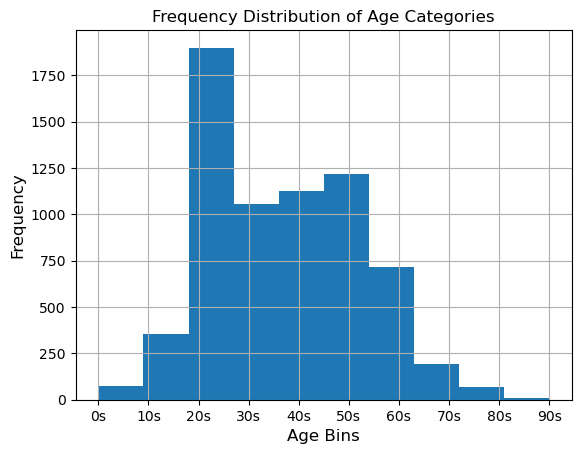

In [51]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(labels=categories['age'])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

In [52]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,5,0
1,0.889746,-0.694899,1,5,0
2,0.917482,-0.682299,1,3,0
3,0.916660,-0.682551,1,3,0
4,0.886074,-0.668883,1,3,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,4,0
6708,-1.728784,1.470871,1,4,0
6709,-1.548071,1.557316,1,4,0
6710,-1.549392,1.555785,1,4,0


***

Create and save the training and holdout datasets.

In [53]:
shuffle_X = X.sample(frac=1.0, random_state=42).reset_index(drop=True)

half = int(np.ceil(shuffle_X.shape[0]/2))

train_data = shuffle_X.iloc[:half,:]
val_data = shuffle_X.iloc[half:,:]

In [54]:
train_data.to_csv("Data/synthetic_datasets/train_dataset.csv", index=False)
val_data.to_csv("Data/synthetic_datasets/holdout_dataset.csv", index=False)

***

Calculate the null accuracy value using bootstrapping on the training data.

In [55]:
null_accuracy = np.mean([rf_bootstrapped_accuracy(train_data) for i in range(100)])

We will use this null for all synthesis models.

In [56]:
null_accuracy

0.4857792014302742

***

Functions for data synthesis using multinomial logistic regression.

In [57]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [58]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [59]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    null_accuracy,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    
    pmse_ratios = rf_accuracy(train_data, sXs)
    
    return pmse_ratios, sXs, GMM

In [60]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       null_accuracy,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        accuracies, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            null_accuracy=null_accuracy,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((null_accuracy - np.mean(accuracies))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.01, 1),
            "C_age_": (0.01, 1),
            "C_state_": (0.01, 1)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(acquisition_function=utility, init_points=5, n_iter=25)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

In [61]:
nsd = 5
ngi = 1
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [62]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, null_accuracy=null_accuracy, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.02758  | 0.1996    | 0.6259    | 0.4434    | 672.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.0242   | 0.7822    | 0.2799    | 0.2837    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.02656  | 0.9586    | 0.8772    | 0.3642    | 501.1     |
| 4         | -0.02703  | 0.6866    | 0.7156    | 0.3765    | 537.3     |
| 5         | -0.02868  | 0.5081    | 0.02363   | 0.7751    | 730.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.02741  | 0.9053    | 0.2054    | 0.1361    | 682.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.02736  | 0.9765    | 0.1574    | 0.4669    | 495.7     |
| 8         | -0.02812  | 0.3517    | 0.7232    | 0.8416    | 408.1     |
| 9         | -0.02591  | 0.4243    | 0.5795    | 0.1003    | 712.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.02933  | 0.9984    | 0.5638    | 0.7402    | 338.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.02854  | 0.9233    | 0.2565    | 0.7494    | 413.3     |
| 12        | -0.02782  | 0.3912    | 0.6115    | 0.6645    | 687.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.03252  | 0.8687    | 0.8097    | 0.5983    | 216.3     |
| 14        | -0.02667  | 0.6325    | 0.3211    | 0.298     | 682.0     |
| 15        | -0.02661  | 0.5034    | 0.453     | 0.1899    | 746.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.02624  | 0.8958    | 0.379     | 0.4229    | 682.1     |
| 17        | -0.02563  | 0.7391    | 0.569     | 0.6045    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.02708  | 0.9992    | 0.5029    | 0.8453    | 681.9     |
| 19        | -0.03146  | 0.3194    | 0.9331    | 0.637     | 283.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.02652  | 0.9794    | 0.9671    | 0.8913    | 650.3     |
| 21        | -0.02729  | 0.4652    | 0.3782    | 0.39      | 682.0     |
| 22        | -0.0285   | 0.193     | 0.9023    | 0.9547    | 571.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.02676  | 0.9379    | 0.135     | 0.549     | 681.6     |
| 24        | -0.02534  | 0.625     | 0.3365    | 0.1587    | 681.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.02658  | 0.8306    | 0.9458    | 0.1815    | 681.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.02914  | 0.845     | 0.7577    | 0.2255    | 350.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.02616  | 0.8936    | 0.7072    | 0.4394    | 681.3     |
| 28        | -0.02751  | 0.2557    | 0.8522    | 0.3483    | 681.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.03097  | 0.9092    | 0.8591    | 0.4       | 252.6     |
| 30        | -0.02524  | 0.2864    | 0.7845    | 0.3158    | 711.6     |
Final Result:  {'target': -0.024204999178263593, 'params': {'C_age_': 0.7821760500376155, 'C_sex_': 0.27986667922981523, 'C_state_': 0.2836996125916657, 'num_components_': 681.9171599767712}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.03061  | 0.08009   | 0.8169    | 0.7702    | 372.1     |
| 2         | -0.02714  | 0.2012    | 0.9791    | 0.4122    | 655.4     |
| 3         | -0.02967  | 0.09826   | 0.3168    | 0.6227    | 476.4     |
| 4         | -0.02794  | 0.2261    | 0.6669    | 0.6819    | 771.1     |
| 5         | -0.02956  | 0.2884    | 0.6237    | 0.3895    | 440.6     |
| 6         | -0.02585  | 0.4933    | 0.9575    | 0.5215    | 657.3     |
| 7         | -0.02985  | 0.1236    | 0.04409   | 0.4295    | 662.4 

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.02613  | 0.7982    | 0.5991    | 0.9234    | 782.9     |
| 13        | -0.02563  | 0.588     | 0.874     | 0.2884    | 787.3     |
| 14        | -0.02635  | 0.7168    | 0.208     | 0.7945    | 791.7     |
| 15        | -0.02545  | 0.4881    | 0.7319    | 0.1876    | 797.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.02566  | 0.9122    | 0.1222    | 0.606     | 800.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.03045  | 0.9139    | 0.7215    | 0.4148    | 320.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.02671  | 0.9909    | 0.4648    | 0.9301    | 601.6     |
| 19        | -0.02649  | 0.7546    | 0.9063    | 0.04899   | 608.3     |
| 20        | -0.02922  | 0.3397    | 0.04567   | 0.03312   | 614.8     |
| 21        | -0.02876  | 0.3342    | 0.1735    | 0.639     | 594.9     |
| 22        | -0.03374  | 0.04226   | 0.01346   | 0.5965    | 544.5     |
| 23        | -0.03122  | 0.1662    | 0.4278    | 0.6438    | 258.0     |
| 24        | -0.03364  | 0.3842    | 0.6923    | 0.743     | 200.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.02563  | 0.775     | 0.8788    | 0.9677    | 711.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.02427  | 0.8467    | 0.5929    | 0.4649    | 718.2     |
| 27        | -0.02734  | 0.6657    | 0.6056    | 0.7632    | 725.0     |
| 28        | -0.02773  | 0.2007    | 0.5541    | 0.1941    | 702.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.02652  | 0.9867    | 0.1468    | 0.5537    | 688.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -0.0275   | 0.8599    | 0.6886    | 0.206     | 679.9     |
Final Result:  {'target': -0.02426994476519733, 'params': {'C_age_': 0.846731733264405, 'C_sex_': 0.5928550233981486, 'C_state_': 0.4648997159290397, 'num_components_': 718.1975943741382}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.03141  | 0.5213    | 0.327     | 0.1765    | 231.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.03332  | 0.9323    | 0.06829   | 0.4413    | 214.9     |
| 3         | -0.0302   | 0.4966    | 0.7043    | 0.7742    | 441.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.03081  | 0.9206    | 0.5488    | 0.6903    | 348.1     |
| 5         | -0.03029  | 0.2518    | 0.568     | 0.2733    | 341.4     |
| 6         | -0.0298   | 0.5857    | 0.1159    | 0.3243    | 312.9     |
| 7         | -0.03038  | 0.4162    | 0.9997    | 0.1782    | 276.7     |
| 8         | -0.02934  | 0.1728    | 0.08301   | 0.4499    | 481.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.0255   | 0.6144    | 0.7354    | 0.9611    | 688.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.02605  | 0.9069    | 0.5406    | 0.1908    | 641.1     |
| 11        | -0.02617  | 0.5399    | 0.866     | 0.4791    | 687.0     |
| 12        | -0.02632  | 0.1904    | 0.567     | 0.4531    | 703.2     |
| 13        | -0.02901  | 0.1603    | 0.2863    | 0.05665   | 621.3     |
| 14        | -0.02538  | 0.2852    | 0.2012    | 0.7945    | 658.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.02615  | 0.9833    | 0.08233   | 0.8447    | 734.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.02581  | 0.7786    | 0.8899    | 0.68      | 756.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.02558  | 0.9738    | 0.2039    | 0.1693    | 778.9     |
| 18        | -0.02616  | 0.2805    | 0.3277    | 0.31      | 800.9     |
| 19        | -0.02668  | 0.5786    | 0.6757    | 0.1669    | 550.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.02715  | 0.7083    | 0.08381   | 0.9903    | 577.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -0.02708  | 0.5125    | 0.7341    | 0.9978    | 523.9     |
| 22        | -0.0296   | 0.1781    | 0.4769    | 0.05378   | 396.0     |
| 23        | -0.03173  | 0.01648   | 0.7651    | 0.2384    | 597.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.02892  | 0.9838    | 0.07514   | 0.06256   | 504.2     |
| 25        | -0.02945  | 0.5785    | 0.0294    | 0.9309    | 373.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.02811  | 1.0       | 0.4577    | 0.2963    | 418.5     |
| 27        | -0.03348  | 0.1823    | 0.2426    | 0.8679    | 254.3     |
| 28        | -0.02782  | 0.579     | 0.932     | 0.7797    | 462.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.02667  | 0.4889    | 0.5249    | 0.9896    | 719.4     |
| 30        | -0.03103  | 0.5838    | 0.1876    | 0.9357    | 294.6     |
Final Result:  {'target': -0.025377838087033224, 'params': {'C_age_': 0.28519611609837636, 'C_sex_': 0.20123205064640165, 'C_state_': 0.7944503901085588, 'num_components_': 658.6829803614407}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.02738  | 0.9742    | 0.9885    | 0.4025    | 547.1     |
| 2         | -0.02976  | 0.5623    | 0.3108    | 0.6339    | 280.9     |
| 3         | -0.02825  | 0.5383    | 0.7421    | 0.9112    | 416.8     |
| 4         | -0.03231  | 0.05371   | 0.809     | 0.6584    | 560.9     |
| 5         | -0.02694  | 0.5891    | 0.1727    | 0.8162    | 541.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -0.02742  | 0.9691    | 0.7184    | 0.3594    | 525.4     |
| 7         | -0.02802  | 0.2317    | 0.2       | 0.7628    | 506.9     |
| 8         | -0.02749  | 0.6584    | 0.3886    | 0.1737    | 485.2     |
| 9         | -0.02738  | 0.5072    | 0.4496    | 0.7226    | 467.4     |
| 10        | -0.0287   | 0.4009    | 0.1769    | 0.07314   | 449.3     |
| 11        | -0.03033  | 0.5066    | 0.1236    | 0.453     | 390.8     |
| 12        | -0.02723  | 0.4649    | 0.5064    | 0.484     | 695.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.02521  | 0.7983    | 0.4247    | 0.3527    | 679.0     |
| 14        | -0.02958  | 0.07183   | 0.5285    | 0.852     | 664.2     |
| 15        | -0.02576  | 0.734     | 0.2449    | 0.2669    | 710.8     |
| 16        | -0.02877  | 0.1022    | 0.9752    | 0.6627    | 722.6     |
| 17        | -0.02826  | 0.1149    | 0.4534    | 0.3123    | 686.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.02728  | 0.9494    | 0.4607    | 0.08863   | 673.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -0.02694  | 0.6019    | 0.9263    | 0.9797    | 704.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.02603  | 0.9395    | 0.7242    | 0.4359    | 800.2     |
| 21        | -0.0267   | 0.3017    | 0.4179    | 0.5999    | 791.6     |
| 22        | -0.0274   | 0.5045    | 0.7564    | 0.6188    | 780.0     |
| 23        | -0.02684  | 0.7089    | 0.1234    | 0.1766    | 766.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -0.02603  | 0.9324    | 0.7591    | 0.9586    | 755.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.02785  | 0.9581    | 0.02371   | 0.3967    | 745.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.03481  | 0.759     | 0.1588    | 0.4752    | 203.1     |
| 27        | -0.03128  | 0.1555    | 0.9937    | 0.1034    | 335.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.02659  | 0.8754    | 0.7101    | 0.5504    | 614.6     |
| 29        | -0.02757  | 0.4424    | 0.1321    | 0.568     | 599.9     |
| 30        | -0.02764  | 0.599     | 0.2402    | 0.7694    | 629.3     |
Final Result:  {'target': -0.025207239220114874, 'params': {'C_age_': 0.7982849482882917, 'C_sex_': 0.4247362431202488, 'C_state_': 0.35265743656779275, 'num_components_': 679.0243076063775}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.03159  | 0.8673    | 0.314     | 0.8171    | 253.5     |


KeyboardInterrupt: 

In [ ]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [ ]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [ ]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [ ]:
best_params

Generate 20 synthetic data sets.

In [ ]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             null_accuracy=null_accuracy,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

In [ ]:
(1 - np.mean(full_ratios))**2

In [ ]:
np.mean(full_ratios)

In [ ]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [ ]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/synthetic_dataset_" + str(i) + ".csv", index=False)

***